Here we develop code to fit latent regression models to data with priors on the projection matrices

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from janelia_core.ml.extra_torch_modules import Bias
from janelia_core.ml.extra_torch_modules import ConstantBoundedFcn
from janelia_core.ml.extra_torch_modules import IndSmpConstantBoundedFcn
from janelia_core.ml.extra_torch_modules import IndSmpConstantRealFcn
from janelia_core.ml.extra_torch_modules import LogGaussianBumpFcn
from janelia_core.ml.extra_torch_modules import SumOfTiledHyperCubeBasisFcns

from janelia_core.ml.latent_regression import GroupMatrixMultiply
from janelia_core.ml.latent_regression import GroupScalarTransform
from janelia_core.ml.latent_regression import LatentRegModel
from janelia_core.ml.latent_regression import LinearMap
from janelia_core.ml.latent_regression import IdentityMap
from janelia_core.ml.latent_regression import vae_fit_latent_reg_model

from janelia_core.ml.torch_distributions import CondBernoulliDistribution
from janelia_core.ml.torch_distributions import CondGaussianDistribution
from janelia_core.ml.torch_distributions import CondSpikeSlabDistribution

from janelia_core.visualization.matrix_visualization import cmp_n_mats

## Parameters go here

In [3]:
n_neurons = [1000]

d_in = n_neurons
d_out = n_neurons

d_proj = [2]
d_trans = [2]

n_smps = 1000

device = 'cpu' # Device to perform fitting on

## Helper functions for visualization

In [4]:
def visualize_mode_mean(d, x_range = [0.0, 1.0], y_range = [0.0, 1.0], n_points_per_side=100):

    orig_device = next(d.parameters()).device
    
    d = d.to('cpu') # Make a copy of model on cpu
    
    grid = np.mgrid[x_range[0]:x_range[1]:n_points_per_side * 1j,
           y_range[0]:y_range[1]:n_points_per_side * 1j]

    grid_vec = np.stack([np.ravel(grid[0, :, :]), np.ravel(grid[1, :, :])]).transpose()
    grid_vec = torch.from_numpy(grid_vec.astype('float32'))

    mn_vec = d(grid_vec).detach().numpy()
    mn_image = np.reshape(mn_vec, [n_points_per_side, n_points_per_side])
    
    plt.imshow(mn_image, extent=[x_range[0], x_range[1], y_range[0], y_range[1]], origin='lower')
    plt.colorbar()
    
    d = d.to(orig_device)

def visualize_mode_pairs(d1, d2, x_range = [0.0, 1.0], y_range = [0.0, 1.0], n_points_per_side=100):
      
    n_modes = len(d1)    
    
    plt.figure()
    
    for m_i in range(n_modes):
            
        # Plot d1 modes in top row
        plt.subplot(2, n_modes, m_i+1)
        visualize_mode_mean(d1[m_i], x_range=x_range, y_range=y_range, n_points_per_side=n_points_per_side)
        
        # Plot d2 modes in second row
        plt.subplot(2, n_modes, m_i+1 + n_modes)
        visualize_mode_mean(d2[m_i], x_range=x_range, y_range=y_range, n_points_per_side=n_points_per_side)

## Define the true conditional priors on mode weights

In [5]:
n_grps = len(n_neurons)

In [6]:
# Spike and slab modes

n_prior_nodes = 20

true_prior_p_dists = [None]*n_grps
true_prior_u_dists = [None]*n_grps

for g in range(n_grps):

    n_grp_modes = [d_proj[g], d_trans[g]]
    for i in range(2):
        # Iterate over p and u modes
        n_cur_modes = n_grp_modes[i]
        proj_mode_dists = [None]*n_cur_modes
        for mode_i in range(n_cur_modes):
            
            spike_log_prob_fcn = LogGaussianBumpFcn(d_x=2, ctr_std_init=0.25, log_gain_init=-0.00001)
            spike_d = CondBernoulliDistribution(spike_log_prob_fcn)
            
            slab_mn_fcn = torch.nn.Sequential(torch.nn.Linear(2,n_prior_nodes), torch.nn.ReLU(), 
                                              torch.nn.Linear(n_prior_nodes, n_prior_nodes), torch.nn.ReLU(), 
                                              torch.nn.Linear(n_prior_nodes,1))
            slab_mn_fcn[4].weight.data = 10*slab_mn_fcn[4].weight.data
            
            slab_std_fcn = ConstantBoundedFcn(lower_bound=np.asarray([.001]), upper_bound=np.asarray([10]), 
                                        init_value=np.asarray(.01))
            
            slab_d = CondGaussianDistribution(mn_f=slab_mn_fcn, std_f=slab_std_fcn)
     
            proj_mode_dists[mode_i] = CondSpikeSlabDistribution(d=1, spike_d=spike_d, slab_d=slab_d)
        
        if i == 0:
            true_prior_p_dists[g] = proj_mode_dists
        else:
            true_prior_u_dists[g] = proj_mode_dists

In [7]:
# Group the true priors by group (so that distributions for p and u modes are together) for convenience
true_prior_mode_dists = list(zip(true_prior_p_dists, true_prior_u_dists))

## Visualize the means of the true distributions on weights

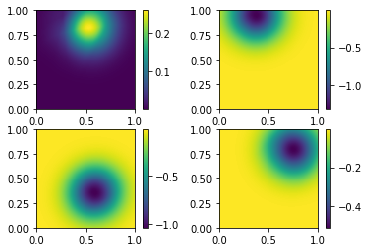

In [8]:
for g in range(n_grps):
        visualize_mode_pairs(true_prior_p_dists[g], true_prior_u_dists[g])

## Generate neuron properties

In [9]:
neuron_props = [torch.zeros(n_neurons[g], 2).uniform_() for g in range(n_grps)]

## Generate true mode weights from the prior that was just defined 

In [10]:
true_p = [None]*n_grps
true_u = [None]*n_grps

for g in range(n_grps):
    n_grp_neurons = n_neurons[g]
    n_grp_modes = [d_proj[g], d_trans[g]]
    
    for i in range(2):
        n_cur_modes = n_grp_modes[i]
        mode_mat = torch.zeros(n_grp_neurons, n_cur_modes)
        for mode_i in range(n_cur_modes):
            mode_mat[:, mode_i] = true_prior_mode_dists[g][i][mode_i].form_standard_sample(
                true_prior_mode_dists[g][i][mode_i].sample(neuron_props[g])).squeeze()
        if i == 0:
            # P modes
            true_p[g] = mode_mat
        else:
            # U modes
            true_u[g] = mode_mat

# Define the true subject model

In [11]:
n_output_groups = len(d_in)

M = IdentityMap()
S = [Bias(d_o) for d_o in d_out]
mdl = LatentRegModel(d_in, d_out, d_proj, d_trans, M, S, direct_pairs=None, noise_range=[.25, .255])

for g, p_g in enumerate(mdl.p):
    p_g.data = true_p[g]
for h, u_h in enumerate(mdl.u):
    u_h.data = true_u[h]

## Generate data

In [12]:
x = [torch.randn([n_smps, d]) for d in d_in]
y = mdl.generate(x)

## Define the subject model we will fit

In [32]:
m_f = IdentityMap() 
#m_f = GroupScalarTransform(d=d_proj)
#m_f = GroupMatrixMultiply(d_in=d_proj, d_out=d_trans)
s_f = [Bias(d_o) for d_o in d_out]
subject_mdl_f = LatentRegModel(d_in, d_out, d_proj, d_trans, m_f, s_f, direct_pairs=None, assign_p_u=False)
subject_mdl_f = subject_mdl_f.to(device)

## Define the inference distribution (  $Q(l, r)$  ) that we will use

In [33]:
q_p_mode_dists = [None]*n_grps
q_u_mode_dists = [None]*n_grps

for g in range(n_grps):
    n_grp_neurons = n_neurons[g]
    for i in range(2):
        if i == 0:
            n_grp_modes = d_proj[g]
        else:
            n_grp_modes = d_trans[g]
    
        q_dists = [None]*n_grp_modes
        
        for mode_i in range(n_grp_modes):
            mn_f = IndSmpConstantRealFcn(n_grp_neurons, init_value=.01)
            std_f = IndSmpConstantBoundedFcn(n_grp_neurons, lower_bound=.0001, upper_bound=10.0, init_value=.2)
            q_dists[mode_i] = CondGaussianDistribution(mn_f=mn_f, std_f=std_f)
            q_dists[mode_i] = q_dists[mode_i].to(device)
        
        if i == 0:
            q_p_mode_dists[g] = q_dists
        else:
            q_u_mode_dists[g] = q_dists

## Define the conditional prior distribution (  $P(l,r|m)$  ) we will fit

In [34]:
class ExpModule(torch.nn.Module):
    def forward(self, x):
        return torch.exp(x) + .01

In [35]:
n_fit_prior_nodes = 20
n_fit_std_prior_nodes = 20

prior_p_dists = [None]*n_grps
prior_u_dists = [None]*n_grps

for g in range(n_grps):
    n_grp_neurons = n_neurons[g]
    for i in range(2):
        if i == 0:
            n_grp_modes = d_proj[g]
        else:
            n_grp_modes = d_trans[g]
            
        prior_dists = [None]*n_grp_modes
        
        for mode_i in range(n_grp_modes):
            #mn_fcn = torch.nn.Sequential(torch.nn.Linear(2,n_fit_prior_nodes), torch.nn.ReLU(), 
             #                                 torch.nn.Linear(n_fit_prior_nodes, n_fit_prior_nodes), torch.nn.ReLU(), 
             #                                 torch.nn.Linear(n_fit_prior_nodes,1))
            #mn_fcn[4].weight.data = 50*mn_fcn[4].weight.data
            
            #std_fcn = torch.nn.Sequential(torch.nn.Linear(2,n_fit_std_prior_nodes), torch.nn.ReLU(), 
            #                                  torch.nn.Linear(n_fit_std_prior_nodes, n_fit_std_prior_nodes), torch.nn.ReLU(), 
             #                                 torch.nn.Linear(n_fit_std_prior_nodes,1), ExpModule())
            
            n_bumps_per_dim = [20, 20]
            dim_ranges = np.asarray([[0, 1.0], [0, 1.0]])
            bump_widths = [.05, .05]
            mn_fcn = SumOfTiledHyperCubeBasisFcns(n_bumps_per_dim, dim_ranges, bump_widths)
            
            std_fcn = ConstantBoundedFcn(lower_bound=np.asarray([.001]), upper_bound=np.asarray([10]), 
                                        init_value=np.asarray(.01))
            
            prior_dists[mode_i] = CondGaussianDistribution(mn_f=mn_fcn, std_f=std_fcn)
            prior_dists[mode_i] = prior_dists[mode_i].to(device)
        
        if i == 0:
            prior_p_dists[g] = prior_dists
        else:
            prior_u_dists[g] = prior_dists

## Send data to device (if it is small enough)

In [36]:
if n_smps <= 1000:
    x = [x_g.to(device) for x_g in x]
    y = [y_h.to(device) for y_h in y]

## Fit everything with variational inference

In [45]:
log = vae_fit_latent_reg_model(l_mdl = subject_mdl_f, q_p_dists=q_p_mode_dists, q_u_dists=q_u_mode_dists, 
                             prior_p_dists=prior_p_dists, prior_u_dists=prior_u_dists, learning_rates = .01,
                             x=x, y=y, x_props=neuron_props, batch_size = 1000, send_size = 1000, update_int=10, 
                             max_its=3000, min_var=.00001, fit_priors=True)

It: 0: Elapsed fitting time 1.3828277587890625e-05, elbo: -12022700.1875, lr: 0.01, GPU mem. usage: nan bytes
    ll: -728154.5625, kl_p_sum: 10979989.0, kl_u_sum: 314556.625
It: 10: Elapsed fitting time 3.9448647499084473, elbo: -7105668.8046875, lr: 0.01, GPU mem. usage: nan bytes
    ll: -798786.625, kl_p_sum: 6149074.0, kl_u_sum: 157808.1796875
It: 20: Elapsed fitting time 7.581600666046143, elbo: -4570321.51953125, lr: 0.01, GPU mem. usage: nan bytes
    ll: -804204.0625, kl_p_sum: 3665519.625, kl_u_sum: 100597.83203125
It: 30: Elapsed fitting time 11.27695083618164, elbo: -3269996.27734375, lr: 0.01, GPU mem. usage: nan bytes
    ll: -804482.125, kl_p_sum: 2390713.375, kl_u_sum: 74800.77734375
It: 40: Elapsed fitting time 14.91550588607788, elbo: -2562010.73046875, lr: 0.01, GPU mem. usage: nan bytes
    ll: -802633.625, kl_p_sum: 1698559.625, kl_u_sum: 60817.48046875
It: 50: Elapsed fitting time 18.687971830368042, elbo: -2142406.66015625, lr: 0.01, GPU mem. usage: nan bytes
   

It: 450: Elapsed fitting time 168.9115698337555, elbo: -817364.0649414062, lr: 0.01, GPU mem. usage: nan bytes
    ll: -735790.0625, kl_p_sum: 70929.703125, kl_u_sum: 10644.29931640625
It: 460: Elapsed fitting time 172.81597185134888, elbo: -815381.0385742188, lr: 0.01, GPU mem. usage: nan bytes
    ll: -736063.625, kl_p_sum: 68769.9296875, kl_u_sum: 10547.48388671875
It: 470: Elapsed fitting time 176.67614698410034, elbo: -813191.4643554688, lr: 0.01, GPU mem. usage: nan bytes
    ll: -736072.375, kl_p_sum: 66674.98828125, kl_u_sum: 10444.10107421875
It: 480: Elapsed fitting time 180.39615082740784, elbo: -810979.5083007812, lr: 0.01, GPU mem. usage: nan bytes
    ll: -735917.25, kl_p_sum: 64737.0546875, kl_u_sum: 10325.20361328125
It: 490: Elapsed fitting time 184.244863986969, elbo: -809147.7578125, lr: 0.01, GPU mem. usage: nan bytes
    ll: -735951.25, kl_p_sum: 62880.107421875, kl_u_sum: 10316.400390625
It: 500: Elapsed fitting time 188.02555298805237, elbo: -807576.4858398438, l

It: 900: Elapsed fitting time 338.2911639213562, elbo: -771061.3178710938, lr: 0.01, GPU mem. usage: nan bytes
    ll: -734128.1875, kl_p_sum: 27785.291015625, kl_u_sum: 9147.83935546875
It: 910: Elapsed fitting time 341.9839949607849, elbo: -770520.322265625, lr: 0.01, GPU mem. usage: nan bytes
    ll: -733972.25, kl_p_sum: 27387.9326171875, kl_u_sum: 9160.1396484375
It: 920: Elapsed fitting time 345.77056097984314, elbo: -770222.5322265625, lr: 0.01, GPU mem. usage: nan bytes
    ll: -734113.375, kl_p_sum: 27031.130859375, kl_u_sum: 9078.0263671875
It: 930: Elapsed fitting time 349.43324089050293, elbo: -769857.03515625, lr: 0.01, GPU mem. usage: nan bytes
    ll: -734044.125, kl_p_sum: 26716.0791015625, kl_u_sum: 9096.8310546875
It: 940: Elapsed fitting time 353.2472698688507, elbo: -769800.3818359375, lr: 0.01, GPU mem. usage: nan bytes
    ll: -734340.125, kl_p_sum: 26370.955078125, kl_u_sum: 9089.3017578125
It: 950: Elapsed fitting time 357.183669090271, elbo: -769408.09765625, l

It: 1350: Elapsed fitting time 507.3097107410431, elbo: -759994.2290039062, lr: 0.01, GPU mem. usage: nan bytes
    ll: -733578.5, kl_p_sum: 17514.427734375, kl_u_sum: 8901.30126953125
It: 1360: Elapsed fitting time 510.99140310287476, elbo: -759579.1264648438, lr: 0.01, GPU mem. usage: nan bytes
    ll: -733286.9375, kl_p_sum: 17365.369140625, kl_u_sum: 8926.81982421875
It: 1370: Elapsed fitting time 514.6964309215546, elbo: -759420.1791992188, lr: 0.01, GPU mem. usage: nan bytes
    ll: -733195.875, kl_p_sum: 17243.1416015625, kl_u_sum: 8981.16259765625
It: 1380: Elapsed fitting time 518.3187699317932, elbo: -760004.1845703125, lr: 0.01, GPU mem. usage: nan bytes
    ll: -733957.8125, kl_p_sum: 17145.78125, kl_u_sum: 8900.5908203125
It: 1390: Elapsed fitting time 521.9595668315887, elbo: -759808.9331054688, lr: 0.01, GPU mem. usage: nan bytes
    ll: -733926.5625, kl_p_sum: 17000.1591796875, kl_u_sum: 8882.21142578125
It: 1400: Elapsed fitting time 525.5913078784943, elbo: -759400.35

It: 1790: Elapsed fitting time 667.9512820243835, elbo: -755927.3559570312, lr: 0.01, GPU mem. usage: nan bytes
    ll: -733400.5, kl_p_sum: 13620.92431640625, kl_u_sum: 8905.931640625
It: 1800: Elapsed fitting time 671.6075298786163, elbo: -755729.2280273438, lr: 0.01, GPU mem. usage: nan bytes
    ll: -733338.4375, kl_p_sum: 13521.36767578125, kl_u_sum: 8869.4228515625
It: 1810: Elapsed fitting time 675.2612838745117, elbo: -755556.8701171875, lr: 0.01, GPU mem. usage: nan bytes
    ll: -733223.0625, kl_p_sum: 13523.02490234375, kl_u_sum: 8810.78271484375
It: 1820: Elapsed fitting time 678.8903679847717, elbo: -755655.595703125, lr: 0.01, GPU mem. usage: nan bytes
    ll: -733266.1875, kl_p_sum: 13434.21923828125, kl_u_sum: 8955.18896484375
It: 1830: Elapsed fitting time 682.5495748519897, elbo: -755669.412109375, lr: 0.01, GPU mem. usage: nan bytes
    ll: -733369.5625, kl_p_sum: 13417.44091796875, kl_u_sum: 8882.40869140625
It: 1840: Elapsed fitting time 686.1442110538483, elbo: -7

It: 2230: Elapsed fitting time 828.0986278057098, elbo: -753657.0844726562, lr: 0.01, GPU mem. usage: nan bytes
    ll: -733118.8125, kl_p_sum: 11715.15673828125, kl_u_sum: 8823.115234375
It: 2240: Elapsed fitting time 831.7698466777802, elbo: -753805.9077148438, lr: 0.01, GPU mem. usage: nan bytes
    ll: -733404.4375, kl_p_sum: 11575.5498046875, kl_u_sum: 8825.92041015625
It: 2250: Elapsed fitting time 835.4285237789154, elbo: -753804.4575195312, lr: 0.01, GPU mem. usage: nan bytes
    ll: -733232.75, kl_p_sum: 11684.36669921875, kl_u_sum: 8887.3408203125
It: 2260: Elapsed fitting time 839.0635979175568, elbo: -753872.173828125, lr: 0.01, GPU mem. usage: nan bytes
    ll: -733393.625, kl_p_sum: 11629.13525390625, kl_u_sum: 8849.41357421875
It: 2270: Elapsed fitting time 842.7696709632874, elbo: -753713.3916015625, lr: 0.01, GPU mem. usage: nan bytes
    ll: -733213.1875, kl_p_sum: 11599.77734375, kl_u_sum: 8900.4267578125
It: 2280: Elapsed fitting time 846.3582899570465, elbo: -75356

It: 2670: Elapsed fitting time 988.8274099826813, elbo: -752767.40625, lr: 0.01, GPU mem. usage: nan bytes
    ll: -733195.875, kl_p_sum: 10712.0615234375, kl_u_sum: 8859.4697265625
It: 2680: Elapsed fitting time 992.5165410041809, elbo: -752980.234375, lr: 0.01, GPU mem. usage: nan bytes
    ll: -733415.125, kl_p_sum: 10651.69921875, kl_u_sum: 8913.41015625
It: 2690: Elapsed fitting time 996.1514148712158, elbo: -752468.6733398438, lr: 0.01, GPU mem. usage: nan bytes
    ll: -732943.1875, kl_p_sum: 10681.46337890625, kl_u_sum: 8844.0224609375
It: 2700: Elapsed fitting time 999.7876398563385, elbo: -752666.5537109375, lr: 0.01, GPU mem. usage: nan bytes
    ll: -733235.375, kl_p_sum: 10619.669921875, kl_u_sum: 8811.5087890625
It: 2710: Elapsed fitting time 1003.4610240459442, elbo: -752642.0825195312, lr: 0.01, GPU mem. usage: nan bytes
    ll: -733155.25, kl_p_sum: 10629.3388671875, kl_u_sum: 8857.49365234375
It: 2720: Elapsed fitting time 1007.1436338424683, elbo: -752593.4975585938,

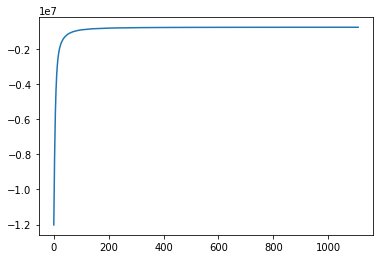

In [46]:
plt.plot(log['elapsed_time'], log['elbo'])

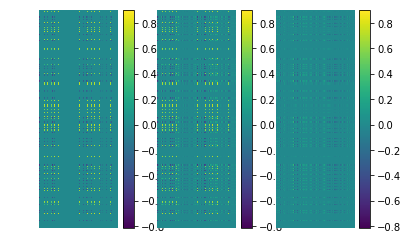

In [47]:
vis_g = 0

true_w = torch.matmul(true_u[vis_g], true_p[vis_g].t()).detach().numpy()

est_p = [d.sample(neuron_props[vis_g]) for d in q_p_mode_dists[vis_g]]
est_p = torch.cat(est_p, dim=1)
#esp_p = torch.matmul(est_p, m_f.w[vis_g])
#est_p = est_p*m_f.v[vis_g]

est_u = [d.sample(neuron_props[vis_g]) for d in q_u_mode_dists[vis_g]]
est_u = torch.cat(est_u, dim=1)

est_w = torch.matmul(est_u, est_p.t()).detach().cpu().numpy()

cmp_n_mats([true_w, est_w, true_w-est_w], show_colorbars=True)


In [48]:
vis_g = 0

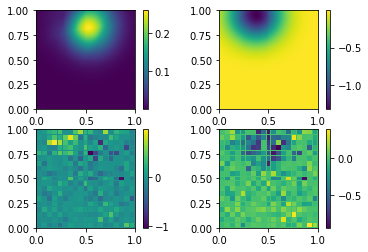

In [49]:
visualize_mode_pairs(true_prior_p_dists[vis_g], prior_p_dists[vis_g])

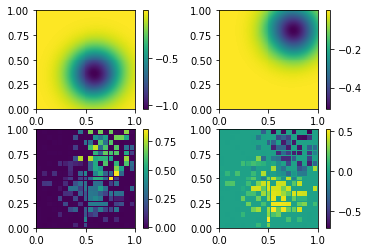

In [50]:
visualize_mode_pairs(true_prior_u_dists[vis_g], prior_u_dists[vis_g])

In [ ]:
m_f.v[0]

In [ ]:
a = torch.tensor([[1.0, 2], [3, 4]])

In [ ]:
a

In [ ]:
b = torch.tensor([1.0, 2.0])

In [ ]:
b.shape

In [ ]:
a*b